## A journey on the Titanic

* Explore the data / Feature Engineering
* Deal with Categorical Variables
* Train and compare the performance of different classifiers

At the end of this tutorial you will be able to build a general machine learning pipeline to solve a classification problem

We start by importing the basic libraries to process data and plotting
** You will need Numpy, Scikit-learn, Pandas and Seaborn - please install Python through Anaconda 
https://www.continuum.io/downloads **

** Also you need to install Xgboost following the instructions here** https://github.com/dmlc/xgboost/tree/master/python-package

In [280]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

import os
import re as re #regular expression search

We then import Scikit-learn (http://scikit-learn.org/stable/) and the classifiers we wants to use from it. We also import cross validation helpers (GridSearchCV, KFold, StratifiedKfold) that will turn useful

In [258]:
import sklearn
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

Finally we import XGboost, which has a Scikit-learn wrapper and a standalone library

In [130]:
#import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper

In [131]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.18.1.


## Let's load the data
we will load the data into a DataFrame using Pandas

In [132]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
full_data = [train, test]

In [133]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [134]:
train.shape

(891, 12)

In [135]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


**We can see that there are several missing values in some of the columns (Age, Cabin, Embarked). We'll have to deal with that**

VARIABLE DESCRIPTIONS:

survival        Survival
                (0 = No; 1 = Yes)
                
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
                
sibsp           Number of Siblings/Spouses Aboard

parch           Number of Parents/Children Aboard

ticket          Ticket Number

fare            Passenger Fare

cabin           Cabin

embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)


### Let's drop the passenger ID as it shouldn't help us

In [136]:
#drop passenger id
print len(train.PassengerId.unique())
train.drop('PassengerId',axis=1)
full_data = [train, test] #extra variable to store all data

891


# Data exploration

## Let's look at the survival rate

In [137]:
train.Survived.unique()

array([0, 1])

In [138]:
train.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

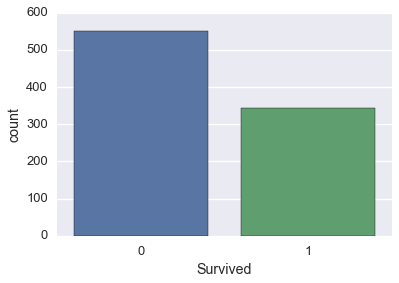

In [139]:
sns.countplot(train.Survived)

### Pclass

In [140]:
train.Survived.groupby(train.Pclass).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

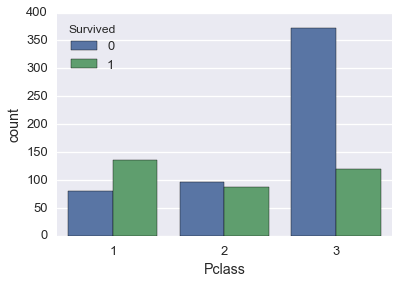

In [141]:
sns.countplot(train.Pclass, hue=train.Survived)

### Sex

In [142]:
ss = train.Survived.groupby(train.Sex).mean()
print ss

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


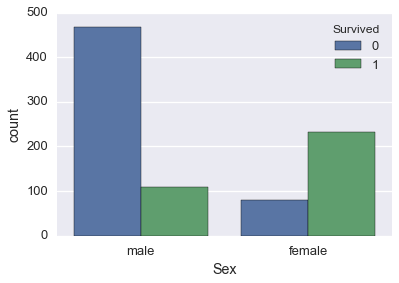

In [143]:
sns.countplot(train.Sex, hue=train.Survived)

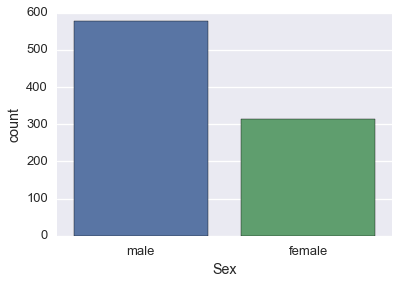

In [144]:
#there are almost 2x more males than females embarked
sns.countplot(train.Sex)

## Baseline classifier accuracy
Let's assume all women survived and all men died. 
We have that 
TP = 74% of the 314 Females survived 
TN = 81% of the 577 Men died

the accuracy is:

TP = 0.74xNf  
TN = 0.81xNm

Acc = (TP+TN)/(Nf+Nm)

In [145]:
print('Baseline acc = %.3f')%((0.74*314+0.81*577)/891)

Baseline acc = 0.785


### Sibling and Parents/Children aboard

** Let's explore how many siblings/spouses/children were aboard**

In [146]:
print np.sort(train.SibSp.unique())
print np.sort(train.Parch.unique())

[0 1 2 3 4 5 8]
[0 1 2 3 4 5 6]


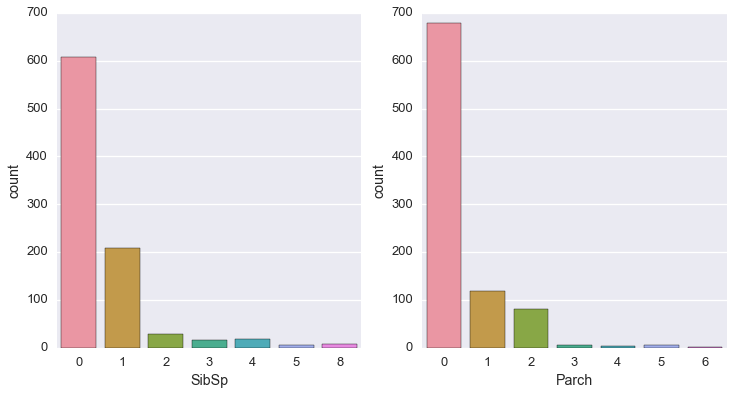

In [147]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
sns.countplot(train.SibSp,ax=ax1)
sns.countplot(train.Parch,ax=ax2)

We can see that most people is alone. Then about 1/3 people has a partner (1) or sibling. About 1/7th has 1 or 2 children

### Let's create a new variable called 'Family size' 

In [148]:
train['FamilySize'] = train['SibSp'] + train['Parch'] +1
test['FamilySize'] = test['SibSp'] + test['Parch'] +1

In [149]:
train.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2


In [150]:
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


### Interestingly people that was not alone and had more than 1 family member aboard had a higher chance of survival!

Let's create a variable called 'isAlone' to denote who is alone

In [151]:
train['isAlone'] = 0
test['isAlone'] = 0

In [152]:
train.loc[train['FamilySize'] == 1,['isAlone']] = 1
test.loc[test['FamilySize'] == 1,['isAlone']] = 1

In [153]:
print(train[['isAlone','Survived']].groupby(['isAlone'])).mean()

         Survived
isAlone          
0        0.505650
1        0.303538


## Names
### Some People had very long names or complex titles. Let's see if that affected survival

In [154]:
train[['Name']].head(10)

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
5,"Moran, Mr. James"
6,"McCarthy, Mr. Timothy J"
7,"Palsson, Master. Gosta Leonard"
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"
9,"Nasser, Mrs. Nicholas (Adele Achem)"


### Let's extract the name title from the name

In [155]:
#alternative shorter solution to find title
# train['Title']= train['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
# test['Title']= test['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])

In [156]:
# train.Title.unique()

** This solution uses regular expressions (Special text string to perform searches into text). It is a bit more complex but returns additional results missed by the other. Let's use it for now **

In [157]:
def get_title(name):
    #the title is always followed by a .
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

train['Title'] = train['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)

In [158]:
# counting the # of observations by sex on the variable Train
print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [159]:
train.Title.value_counts(normalize=True)

Mr          0.580247
Miss        0.204265
Mrs         0.140292
Master      0.044893
Dr          0.007856
Rev         0.006734
Col         0.002245
Major       0.002245
Mlle        0.002245
Countess    0.001122
Ms          0.001122
Lady        0.001122
Jonkheer    0.001122
Don         0.001122
Mme         0.001122
Capt        0.001122
Sir         0.001122
Name: Title, dtype: float64

We see that some titles are really rare. Let's replace them with a 'Rare' title. Also some female titles are interchangeable, so we want to merge them

In [160]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


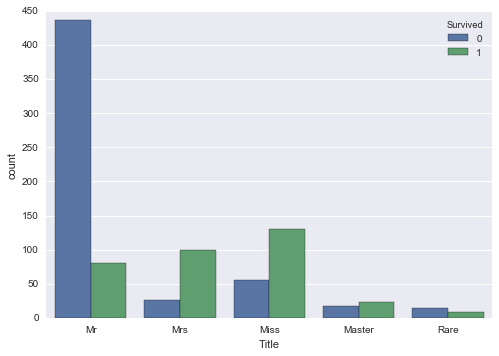

In [161]:
sns.set_context("notebook")
sns.countplot(train.Title, hue=train.Survived)

'Mr' had low survival rate with respect to 'Masters' 

### Name Length
Some names are really long. Let's look at their distribution

In [162]:
train[['Name']].head(6)

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
5,"Moran, Mr. James"


In [163]:
train['Name_Len']=train.Name.apply(lambda x: len(x))

(array([ 140.,  318.,  264.,   72.,   49.,   36.,    8.,    3.,    0.,    1.]),
 array([ 12.,  19.,  26.,  33.,  40.,  47.,  54.,  61.,  68.,  75.,  82.]),
 <a list of 10 Patch objects>)

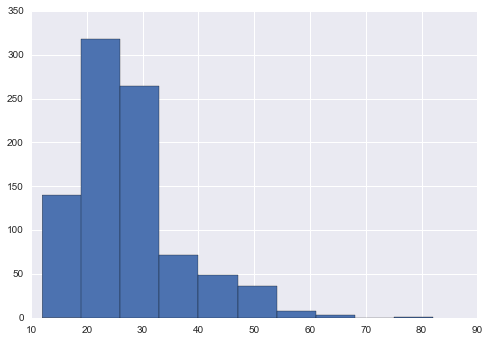

In [164]:
plt.hist(train.Name_Len)

In [165]:
snl = train.Survived.groupby(train.Name_Len).mean()
print snl[:10]

Name_Len
12    0.500000
13    0.500000
14    0.333333
15    0.133333
16    0.230769
17    0.214286
18    0.200000
19    0.234375
20    0.282051
21    0.325000
Name: Survived, dtype: float64


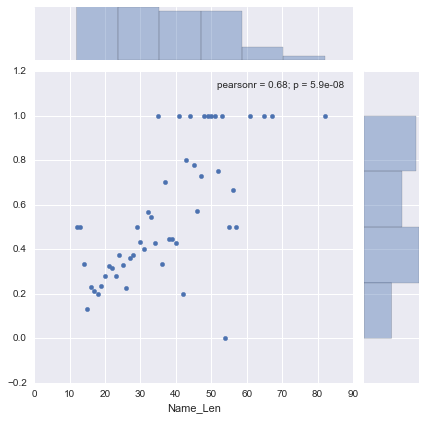

In [166]:
sns.jointplot(snl.index,snl.values)

### there seems to be a positive correlation between name length and survival rate!

## Tickets

There are some duplicates, which seem to be related to the memebrs of the same family. Maybe this could be used as a feature

In [167]:
train[['Ticket']].head(10)

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450
5,330877
6,17463
7,349909
8,347742
9,237736


In [168]:
len(np.unique(train[['Ticket']]))

681

Let's verify there are no missing values

In [169]:
sum(train.Ticket.isnull())

0

In [170]:
len(train[train['Ticket'].duplicated()==True])

210

Let's look at the first 3 duplicated tickets

In [171]:
train[train['Ticket'].duplicated()==True].Ticket[:3]

24     349909
71    CA 2144
88      19950
Name: Ticket, dtype: object

Let's visualize one duplicated ticket to make sure it belongs to the same family

In [172]:
train[train['Ticket']=='349909']
#train[train['Ticket']=='CA 2144']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,isAlone,Title,Name_Len
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,NaN,S,5,0,Master,30
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.075,NaN,S,5,0,Miss,29
374,375,0,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.075,NaN,S,5,0,Miss,26
567,568,0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S,5,0,Mrs,43


Now create a 'FamilyTicket' feature 

In [173]:
train['FamilyTicket'] = train['Ticket'].duplicated()==True

We can use LabelEncoder to convert the True/False category into 0 and 1. (Can be in other ways too)

In [174]:
enc = LabelEncoder()
train['FamilyTicket'] = enc.fit_transform(train['FamilyTicket'])

In [175]:
train.FamilyTicket.unique()

array([0, 1])

## Age

there are 177 null values.

In [176]:
train[train['Age'].isnull()].shape #null values

(177, 17)

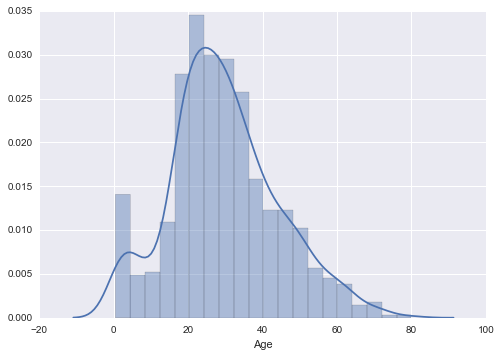

In [177]:
# plt.hist(train[~train['Age'].isnull()].Age,bins=20) #uses matplotlib basics
sns.distplot(train[~train['Age'].isnull()].Age,bins=20)

Let's discretize age into groups. We can discretize the variable Age by **quantiles** (each quantile contains approx the same fraction of the total population) or by **values**

In [178]:
qc = pd.qcut(train['Age'],5).value_counts()
qc.sort_index()
#quantization by values
# c = pd.cut(train['Age'],5).value_counts()
# c.sort_index()

[0.42, 19]    164
(19, 25]      137
(25, 31.8]    127
(31.8, 41]    144
(41, 80]      142
Name: Age, dtype: int64

## Dealing with missing Age data

There are several strategies to deal with missing data (see for example http://machinelearningmastery.com/handle-missing-data-python/). A basic approch (beyond discarding the data, which we want to avoid) is to use the replace the missing values with the mean or median, or to randomly draw from a distribution (e.g. Gaussian) with mean equal to that of our population. We'll follow this approach

In [179]:
mu = train['Age'].mean()
std = train['Age'].std()

In [180]:
#fill nan with random gaussian distribution 
train.loc[train['Age'].isnull(),'Age'] = std*np.random.randn(177,1) + mu
#fill nan with median age 
#train.loc[train['Age'].isnull(),'Age'] = np.nanmedian(train['Age'])

In [181]:
np.sum(train.Age.isnull())

0

### Now let's discretize the age values and let's plot the survival rate by age group

In [182]:
train.loc[train['Age'] <=19, 'Age_group'] = 0
train.loc[(train['Age'] > 19) & (train['Age'] <= 25), 'Age_group'] = 1
train.loc[(train['Age'] > 25) & (train['Age'] <= 31.8), 'Age_group'] = 2
train.loc[(train['Age'] > 31.8) & (train['Age'] <= 41), 'Age_group'] = 3
train.loc[train['Age'] > 41, 'Age_group'] = 4

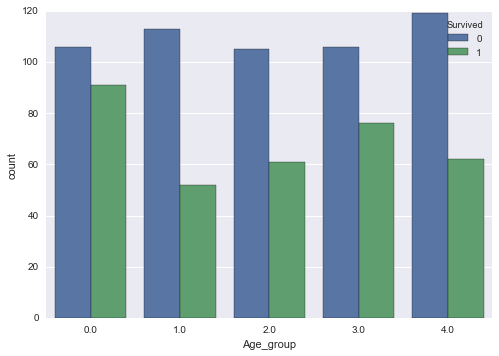

In [183]:
sns.countplot(train.Age_group,hue=train.Survived)

## Fare
Let's look at its distribution. We'll likely have to discretize this variable as well

In [184]:
np.sum(train.Fare.isnull())

0

In [185]:
print train.Fare.max()
print train.Fare.min()

512.3292
0.0


### Only 3 people paid the highest fare and 15 paid a fare of 0.0 (lucky ones?) 

In [186]:
print len(train[train['Fare'] == 0.0])
print len(train[train['Fare'] == train.Fare.max()])

15
3


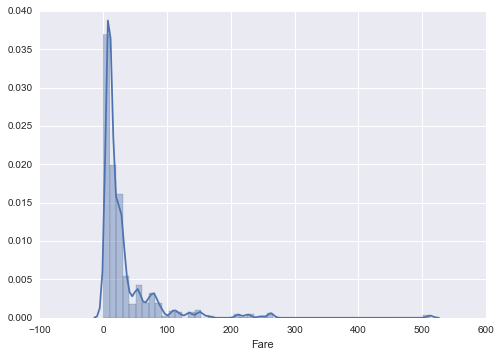

In [187]:
sns.distplot(train.Fare)

### let's define bins at defined cut points (0 to 50, 51 to 160,...)
** Note that we need to provide a negative value for the 1st left bin edge as it is excluded**

In [188]:
bins = [-1, 50, 100, 190, 300, 520]
#group_names = ['Low', 'Normal', 'Rich', 'Very-Rich'] #you can use whatever you like
group_names = [0,1,2,3,4]
print pd.cut(train.Fare,bins).value_counts() 
train['FareGroup'] = pd.cut(train.Fare,bins,labels=group_names)

(-1, 50]      731
(50, 100]     107
(100, 190]     33
(190, 300]     17
(300, 520]      3
Name: Fare, dtype: int64


In [189]:
np.sort(train.FareGroup.unique())

array([0, 1, 2, 3, 4])

### Let's look  at the survival rate based on the fare

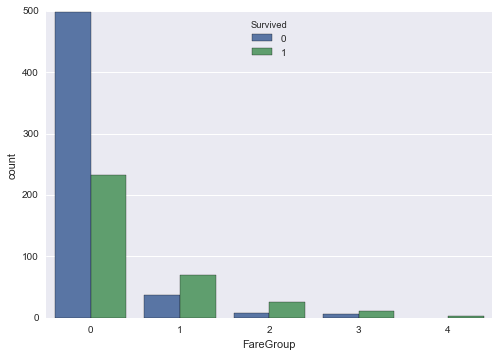

In [190]:
sns.countplot(train.FareGroup,hue=train.Survived)

As expected people with lower class tickets had a lower survival rate

## Compare performance of different Classifiers

** We have created a lot of extra features. Let's look at all the features and decide which one we will use ** 

** Note that we did not look at 'Cabin', as well as the 'Embarked' port. That could contain also important information. We leave the reader for exploration on that**

In [191]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,isAlone,Title,Name_Len,FamilyTicket,Age_group,FareGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr,23,0,1.0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs,51,0,3.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss,22,0,2.0,0


In [192]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
PassengerId     891 non-null int64
Survived        891 non-null int64
Pclass          891 non-null int64
Name            891 non-null object
Sex             891 non-null object
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Ticket          891 non-null object
Fare            891 non-null float64
Cabin           204 non-null object
Embarked        889 non-null object
FamilySize      891 non-null int64
isAlone         891 non-null int64
Title           891 non-null object
Name_Len        891 non-null int64
FamilyTicket    891 non-null int64
Age_group       891 non-null float64
FareGroup       891 non-null category
dtypes: category(1), float64(3), int64(9), object(6)
memory usage: 126.3+ KB


In [193]:
#let's drop cols that are not useful
train = train.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin','Embarked'],axis=1)

In [194]:
train.head()

,Survived,Pclass,Sex,Age,Fare,FamilySize,isAlone,Title,Name_Len,FamilyTicket,Age_group,FareGroup
0,0,3,male,22.0,7.2500,2,0,Mr,23,0,1.0,0
1,1,1,female,38.0,71.2833,2,0,Mrs,51,0,3.0,1
2,1,3,female,26.0,7.9250,1,1,Miss,22,0,2.0,0
3,1,1,female,35.0,53.1000,2,0,Mrs,44,0,3.0,1
4,0,3,male,35.0,8.0500,1,1,Mr,24,0,3.0,0


## Transform categorical variables

We need to transform categorical variables into numeric (not all classifiers can deal with categorical!)

Below I use a pandas method (cat.codes). 

It is also possible to use a label encoder 
https://www.analyticsvidhya.com/blog/2015/11/easy-methods-deal-categorical-variables-predictive-modeling/

The age group will however lose the information of the actual age, which is relevant for the classification task. Therefore it is also possible to extract **new features** from Age group itself. For example consider including min and max of the age group or the mode or median of that age group

We need to explicitly cast categorical variables into 'category' if they are not automatically recognized as such

In [195]:
#cast types into categorical and int
train['Sex'] = train['Sex'].astype('category')
train['Title'] = train['Title'].astype('category')
train['Age_group'] = train['Age_group'].astype('int')

Let's revise the variables are now correctly labeled as categorical type

In [196]:
cat_cols = train.select_dtypes(['category']).columns

In [197]:
cat_cols

Index([u'Sex', u'Title', u'FareGroup'], dtype='object')

In [198]:
train[cat_cols] = train[cat_cols].apply(lambda x: x.cat.codes)

In [199]:
train.head()

,Survived,Pclass,Sex,Age,Fare,FamilySize,isAlone,Title,Name_Len,FamilyTicket,Age_group,FareGroup
0,0,3,1,22.0,7.2500,2,0,2,23,0,1,0
1,1,1,0,38.0,71.2833,2,0,3,51,0,3,1
2,1,3,0,26.0,7.9250,1,1,1,22,0,2,0
3,1,1,0,35.0,53.1000,2,0,3,44,0,3,1
4,0,3,1,35.0,8.0500,1,1,2,24,0,3,0


Now all features are numeric! Let's finally split our data into matrices of features (X) and response (y)

In [200]:
X = train.drop('Survived',axis=1).as_matrix()
y = train[['Survived']].as_matrix().reshape(-1)

## Comparing different models

For comparing different models and at the same time tuning the hyperparameters of each model we will use a grid search approach, combined with cross-validation. 

Let's start by defining our models and the range of hyper parameters to try for each

In [218]:
models = [[ RandomForestClassifier(random_state=2), {'n_estimators': [10,50,100,200]}, "Random Forest"]]

#see also: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
models.append([GradientBoostingClassifier(random_state=2), {'n_estimators':[100,150,200], 'max_depth':[2,3,4,5]}, "GradientBoost" ])

models.append([neighbors.KNeighborsClassifier(), {'n_neighbors': [1, 3, 5, 7, 10,20], 'weights': ['uniform','distance']},
               "K-Nearest Neighbors"])

#default is L2 regularization (ridge regression). C is the inverse of regularization strength. 
models.append([linear_model.LogisticRegression(random_state=10), {'C': [0.001, 0.01, 0.1, 1, 2, 10]}, "Logistic Regression"])

Let's initialize an XGboost classifier separately

In [219]:
#define an XGboost classifier using the Sklearn wrapper (XGBClassifier)
xgbclf = XGBClassifier(n_estimators=1000,
    #learning_rate=0.02
    max_depth=4, #default=6
    min_child_weight=2, #default=1
    gamma=0.9, #minimum loss reduction required to make a split. (default=0)
    subsample=1, # Denotes the fraction of observations to be randomly samples for each tree (default=1)
    colsample_bytree=1, #Similar to max_features in GBM. 
                        #Denotes the fraction of columns to be randomly samples for each tree.
    #binary:logistic – logistic regression for binary classification, returns predicted probability (not class)                   
    objective= 'binary:logistic',
    #A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence (default=1)
    scale_pos_weight=1,nthread=-1,seed=10)

In [220]:
xgbclf

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.9, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=10, silent=True, subsample=1)

Now we can append this classifier to the list of our models and define a range of hyper parameters for it

In [221]:
models.append([xgbclf,{'max_depth':range(3,6), 'min_child_weight':range(1,6,2), 'gamma':[i/10.0 for i in list(np.linspace(0,5,num=3))]},'XGB'])

Now we can start the grid search for each model, using a 10-fold cross validation

In [222]:
import time

In [223]:
start_time = time.time()
best_estimator = []

for model in models:
    clf = GridSearchCV(model[0],model[1],cv=10,n_jobs=-1)
    clf.fit(X,y)
    best_params = clf.best_params_
    best_estimator.append(clf.best_estimator_)
    #means = clf.cv_results_['mean_test_score']
    print('Best Estimator ',clf.best_estimator_)
    print('\n')
    print("Best parameters for ", model[2], " : ", best_params)
    print('Best score %.3f'%(clf.best_score_))
    print('\n')
    
end_time = time.time()
print("Elapsed time was %g seconds" % (end_time - start_time)) 

('Best Estimator ', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=2,
            verbose=0, warm_start=False))


('Best parameters for ', 'Random Forest', ' : ', {'n_estimators': 50})
Best score 0.826


('Best Estimator ', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False))


('Best parameters for ', 'GradientBoost', ' : ', {'n_est

## Let's look at the feature importance yielded by the ensembles

In [207]:
predictors = train.columns[1:]
target = train.columns[0]

In [208]:
rf_model = best_estimator[0]
gb_model = best_estimator[1]
xgb_model = best_estimator[-1]

In [209]:
models = [rf_model, gb_model, xgb_model]

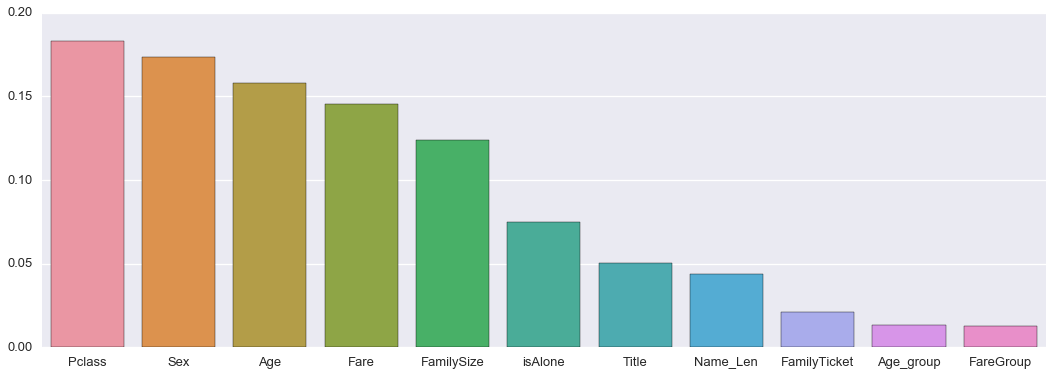

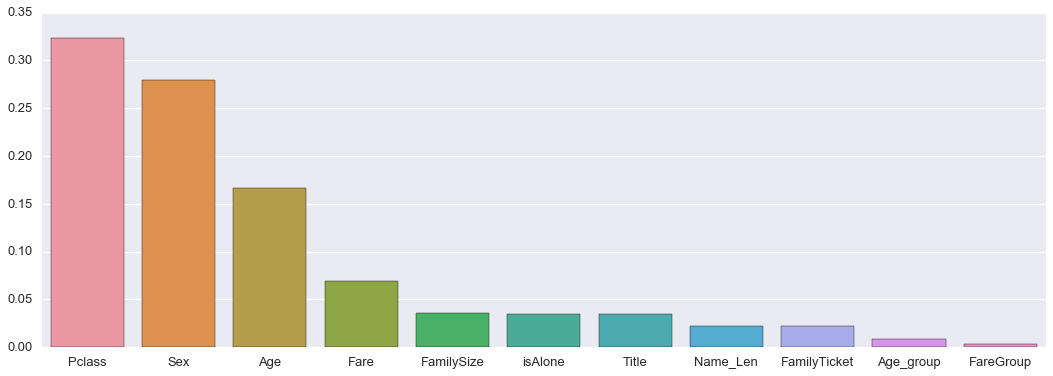

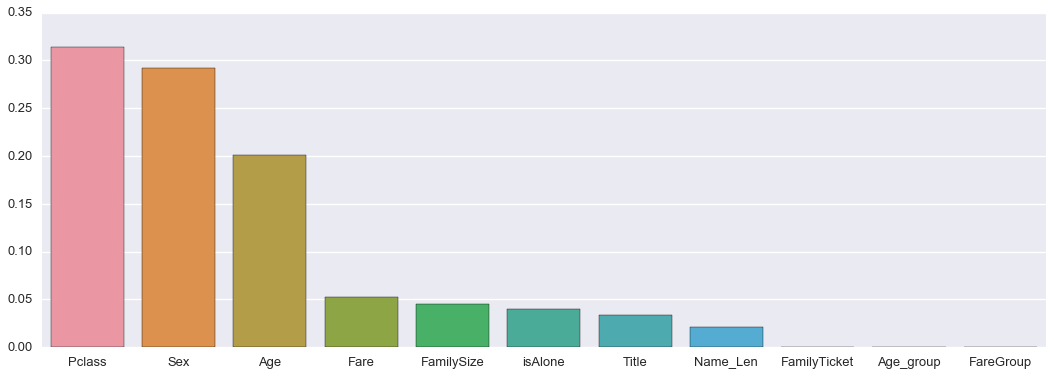

In [210]:
sns.set_context("talk")

for model in models:
    importance = model.feature_importances_
    indices = np.argsort(importance); indices = indices[::-1]
    plt.figure(figsize=(18,6))    
    ax = sns.barplot(x=predictors,y=importance[indices])
#     print np.sum(importance[indices])


## Finally let's look at the ROC curves of our classifiers

** Note: I have a problem displaying the legend - need to fix this **

An ROC curve displays the ratio of true positive rate (sensitivity) over false positive rate (1-specificity) at different thresholds. It is useful to evaluate the performance of a binary classifier in terms of these 2 parameters

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [238]:
models = [RandomForestClassifier(n_estimators=50,random_state=2), GradientBoostingClassifier(n_estimators=200,max_depth=4),
         XGBClassifier(max_depth=3,gamma=0.25,min_child_weight=1)]

Acc = 0.807, AUC = 0.880, Sens = 0.717, Spec = 0.874
Acc = 0.810, AUC = 0.867, Sens = 0.750, Spec = 0.857
Acc = 0.844, AUC = 0.886, Sens = 0.750, Spec = 0.914


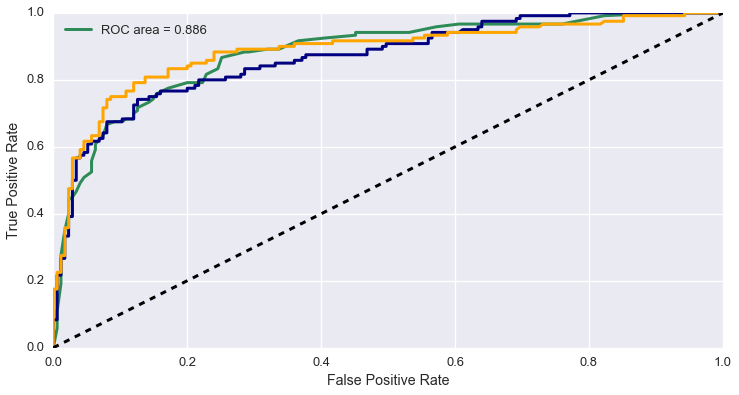

In [312]:
#for plotting
from itertools import cycle
colors = cycle(['seagreen', 'navy', 'orange'])
lw = 3 #line-width
plt.figure(figsize=(12,6))

ypred_all = []; yscore_all = []
for clf,color in zip(models,colors):
#     print clf.get_params #sanity check to show classifier name and params
    clf.fit(X_train,y_train)
    ypred = clf.predict(X_test)
    yscore = clf.predict_proba(X_test)
    yscore = yscore[:,1]
    acc = np.sum(ypred==y_test)/len(y_test)
    ypred_all.append(ypred)
    yscore_all.append(yscore)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    ind_t = np.where(thresholds <= 0.51);
    print 'Acc = %.3f, AUC = %.3f, Sens = %.3f, Spec = %.3f'%(acc,roc_auc,tpr[ind_t[0][0]],1-fpr[ind_t[0][0]])
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC area = %0.3f' %(roc_auc))
    plt.legend(['ROC area = %0.3f'%(roc_auc)],loc='best')


plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')
# plt.legend(['ROC area = %0.3f'%(roc_auc)],loc='best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Interestingly, the AUC of the random forest classifier is close to that of Xgboost, while that of Gradient boosting is the lowest. This is because the problem shows a high class imbalance and therefore accuracy might not a good metric to evaluate our classifier.

### Next things to try

* Look at how correlated are the predictions of our 3 winning classifiers. If they are uncorrelated, it is a good sign that they can be combined to build a better classifier (see below)

* Try stacking (e.g. Use the predictions of our 3 classifiers as a features of another classifer

* Try to impute missing values in a different way (e.g. predict missing age data from other features)

* Try other features, such as cabin. Will need some feature engineering 